# LSTM: Many-to-many setup

### Progress:
* [x] The custom max-ent loss function is added but the weight need to tune.
* [ ] The data extraction and test code need to be aligned with filter

In [15]:
import re
import numpy as np
import unidecode
from keras.preprocessing.sequence import pad_sequences
from IPython import get_ipython;   
#get_ipython().magic('reset -sf')
import pandas
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense,Dropout,Softmax,Flatten,concatenate
from keras.layers import LSTM
from keras.layers import *
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
from IPython.display import Image

import pickle
import glob
from datetime import datetime

In [2]:
# The function to extract training data from pickles
def extract_data(pklfiles_to_process, file_num, crop=None):
    with open(pklfiles_to_process[file_num], 'rb') as f:
        dataset_all = pickle.load(f)

    # All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    history_traj_data = np.array(dataset_all['features'])[:, :, :3]

    # All the future trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    future_traj_data = np.array(dataset_all['labels'])[:, :, :2]

    # All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
    goals_position = np.array(dataset_all['goals'])
    goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

    # All intention labels, with shape (batch_size, goal_nums)
    goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
    # Convert to one-hot and the last one is undecided (-1)
    one_hot_goal = to_categorical(goal_idx, num_classes=33)
    
    if crop is not None:
        pass
    
    return history_traj_data, future_traj_data, goals_position, one_hot_goal

In [3]:
pklfiles_to_process = glob.glob('./*.pkl')

print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process, file_num)

Found 6 pkl files: ['./pilot_dataset_11_26_16_54_22.pkl', './pilot_dataset_11_26_16_54_22_fold_0.pkl', './pilot_dataset_11_26_16_54_22_fold_1.pkl', './pilot_dataset_11_26_16_54_22_fold_2.pkl', './pilot_dataset_11_26_16_54_22_fold_3.pkl', './pilot_dataset_11_26_16_54_22_fold_4.pkl']


In [4]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM
import keras.backend as K # for custom loss function

def max_ent_loss(y_true, y_pred, beta=0.2):
    loss1 = K.categorical_crossentropy(y_true, y_pred)
    loss2 = K.categorical_crossentropy(y_pred, y_pred)
    loss  = loss1 + beta * loss2
    return loss

def top_k_acc(y_true, y_pred, k=3):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def create_goal_model(traj_input_shape,goal_input_shape, hidden_dim,n_outputs):
    
    # Input to lstm
    lstm_input = Input(shape=(traj_input_shape),name="input_trajectory")
    
    # LSTM unit
    lstm = LSTM(hidden_dim,return_state=True,name="lstm_unit")
    
    # LSTM outputs
    lstm_outputs, state_h, state_c = lstm(lstm_input)
    
    # Input for goals
    goals_input = Input(shape=(goal_input_shape),name="goal_input")
    
    # Merge inputs with LSTM features
    concat_input = concatenate([goals_input,lstm_outputs],name="stacked_input")
    
    concat_output = Dense(100, activation="relu", name="concat_relu")(concat_input)
    
    # Final FC layer with a softmax activation
    goal_output = Dense(n_outputs,activation="softmax",name="goal_output")(concat_output)
        
    # Create final model
    model = Model([lstm_input,goals_input], goal_output)
    
    # Compile model using loss
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=max_ent_loss, optimizer='adam', metrics=[top_k_acc])
    
    return model    

In [5]:
print('Shape of history_traj:', history_traj_data.shape)
print('Shape of goals_position:', goals_position.shape)
print('Shape of one_hot_goal label:', one_hot_goal.shape)

traj_input_shape=(history_traj_data.shape[1], history_traj_data.shape[2])
goal_input_shape=(goals_position.shape[1],)
hidden_dim = 100
n_outputs = one_hot_goal.shape[1]
goal_model = create_goal_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs)
plot_model(goal_model,to_file='goal_model.png')
print(goal_model.summary())

# traj_model = create_trajectory_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs)

# plot_model(traj_model,to_file='traj_model.png')
# display(HTML("<table><tr><td><title>A</title><img src='model.png'></td><td><img src='traj_model.png'></td></tr></table>"))

Shape of history_traj: (1763, 5, 3)
Shape of goals_position: (1763, 96)
Shape of one_hot_goal label: (1763, 33)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_trajectory (InputLayer)   (None, 5, 3)         0                                            
__________________________________________________________________________________________________
goal_input (InputLayer)         (None, 96)           0                                            
__________________________________________________________________________________________________
lstm_unit (LSTM)                [(None, 100), (None, 41600       input_trajectory[0][0]           
__________________________________________________________________________________________________
stacked_input (Concatenate)     (None, 196)          0           goal_input[0][0]               

Goal Model Structure:
<img src='goal_model.png' width=300 height=300>

In [6]:
# Train the goal model
goal_history = goal_model.fit([history_traj_data, goals_position], one_hot_goal, epochs=100, validation_split=0.33)

Train on 1181 samples, validate on 582 samples
Epoch 1/100
1181/1181 [==============================] - 4s 3ms/step - loss: 6.2092 - top_k_acc: 0.3497 - val_loss: 4.0254 - val_top_k_acc: 0.5103
Epoch 2/100
1181/1181 [==============================] - 1s 542us/step - loss: 3.5672 - top_k_acc: 0.5953 - val_loss: 3.2087 - val_top_k_acc: 0.6254
Epoch 3/100
1181/1181 [==============================] - 1s 476us/step - loss: 2.9173 - top_k_acc: 0.6960 - val_loss: 2.7399 - val_top_k_acc: 0.6821
Epoch 4/100
1181/1181 [==============================] - 1s 496us/step - loss: 2.7323 - top_k_acc: 0.7163 - val_loss: 2.4874 - val_top_k_acc: 0.7010
Epoch 5/100
1181/1181 [==============================] - 1s 493us/step - loss: 2.4770 - top_k_acc: 0.7756 - val_loss: 2.2548 - val_top_k_acc: 0.7835
Epoch 6/100
1181/1181 [==============================] - 1s 502us/step - loss: 2.2627 - top_k_acc: 0.7968 - val_loss: 2.0748 - val_top_k_acc: 0.8144
Epoch 7/100
1181/1181 [==============================] - 1s 4

dict_keys(['val_loss', 'val_top_k_acc', 'loss', 'top_k_acc'])


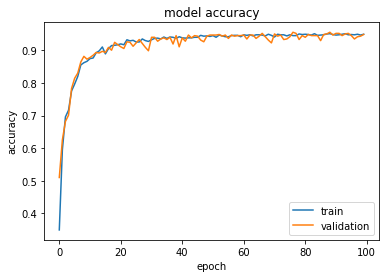

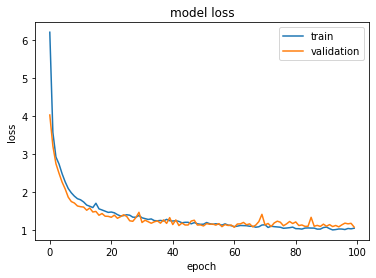

In [26]:
print(goal_history.history.keys())
# summarize history for accuracy
plt.plot(goal_history.history['top_k_acc'])
plt.plot(goal_history.history['val_top_k_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(goal_history.history['loss'])
plt.plot(goal_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [11]:
# save model and architecture to single file
now = datetime.now()
dt_string = now.strftime('%m_%d_%H_%M')
file_name = "goal_model_%.4f_%s.h5" % (goal_history.history['val_top_k_acc'][-1], dt_string)
goal_model.save(file_name)
print("Saved goal model to disk")

Saved goal model to disk


In [18]:
# Get test data
file_num = 5
test_hist_traj, test_future_traj, test_goals_position, test_one_hot_goal = extract_data(pklfiles_to_process, file_num)

# Load model from disk
load_model = False
if load_model:
    model_files_on_disk = glob.glob('./goal_model_*.h5')
    print('Model files on disk: %s' % model_files_on_disk)
    goal_model = load_model(model_files_on_disk[-1])
    
# Use the goal model to predict
goal_pred = goal_model.predict([test_hist_traj, test_goals_position])

/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


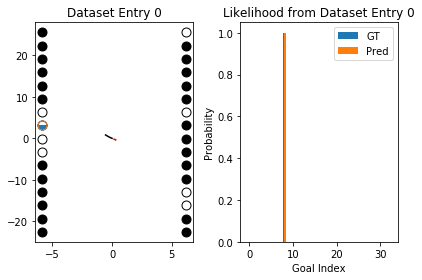

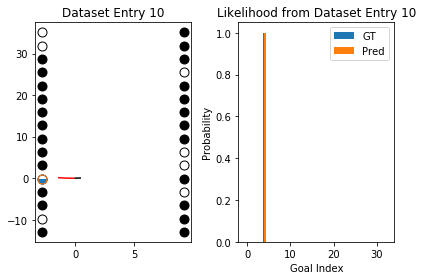

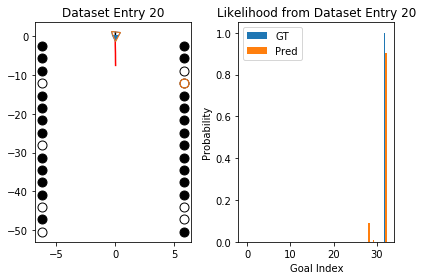

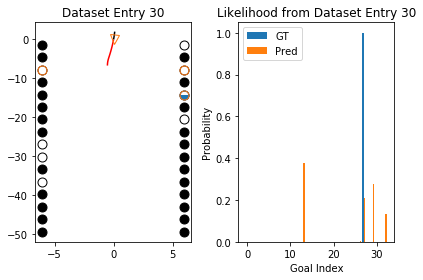

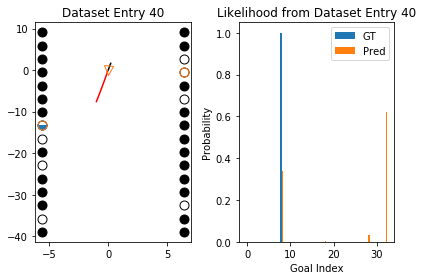

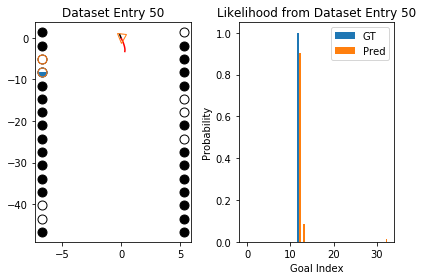

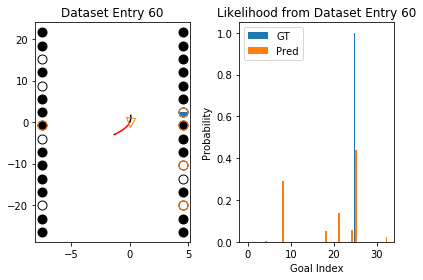

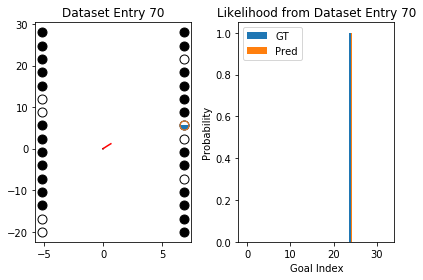

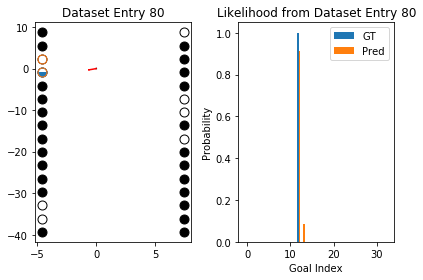

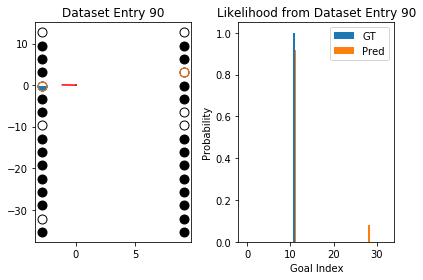

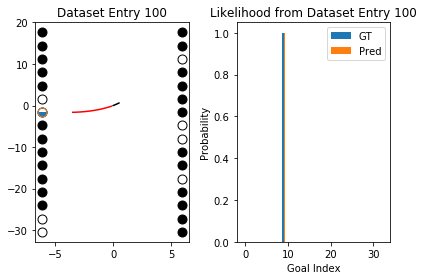

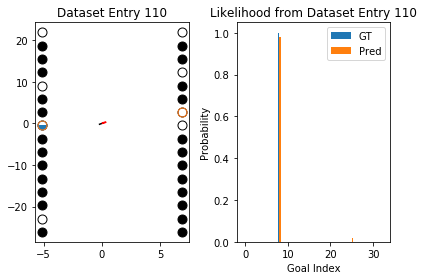

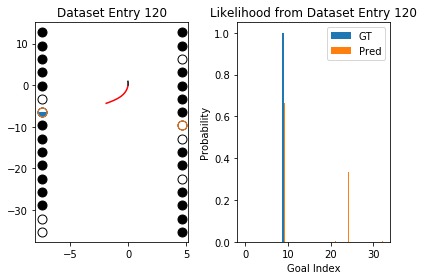

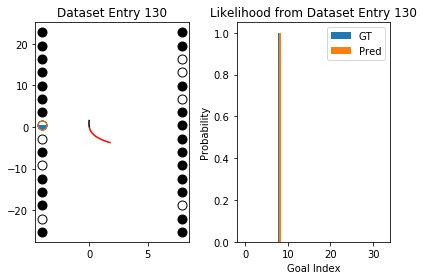

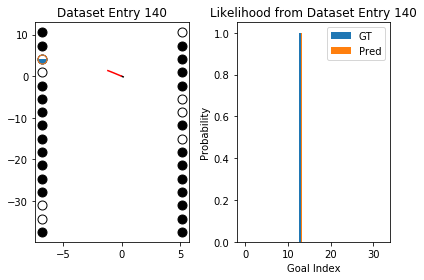

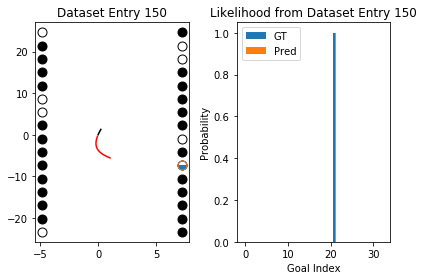

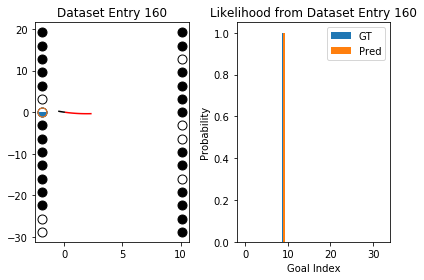

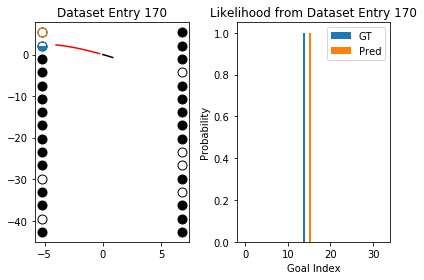

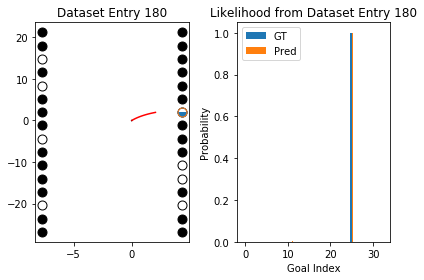

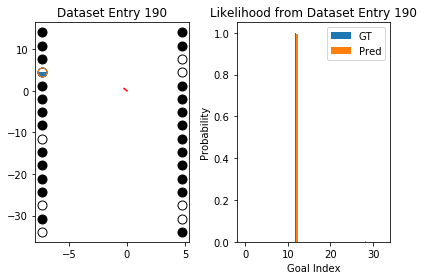

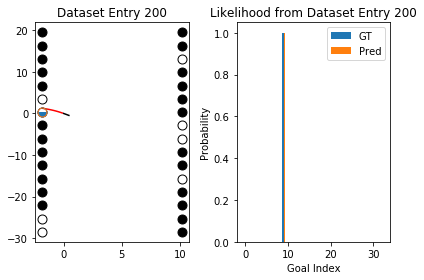

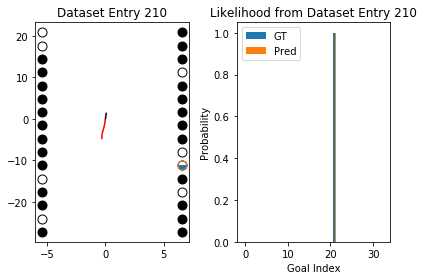

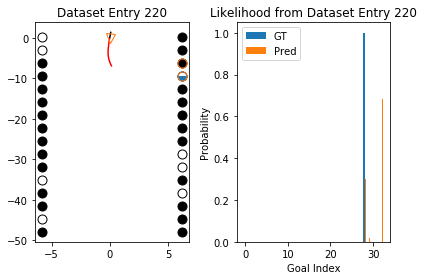

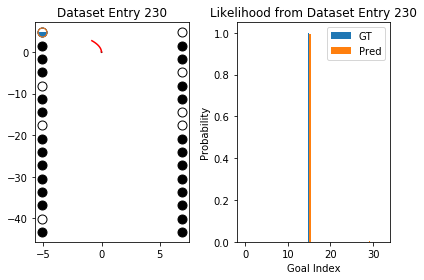

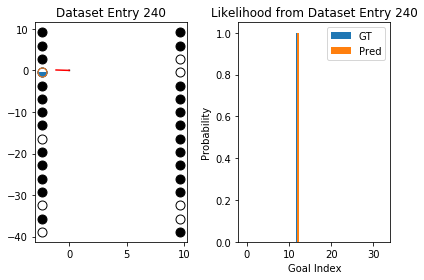

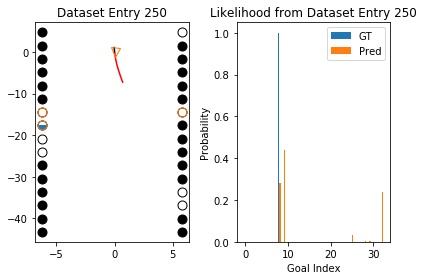

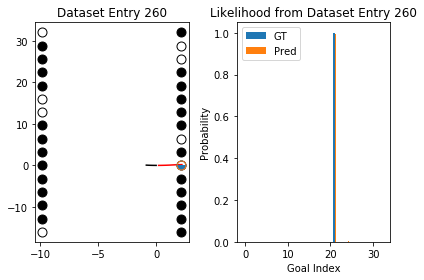

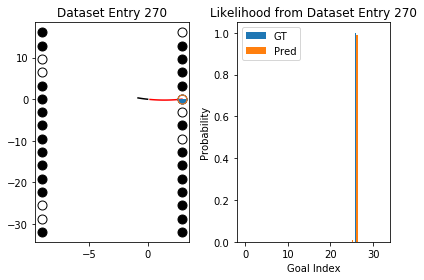

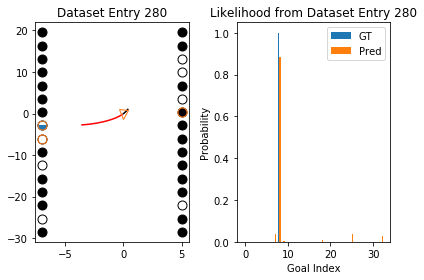

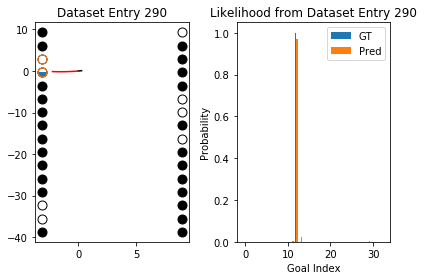

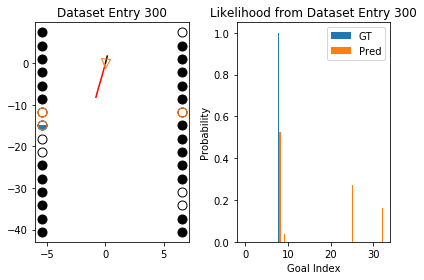

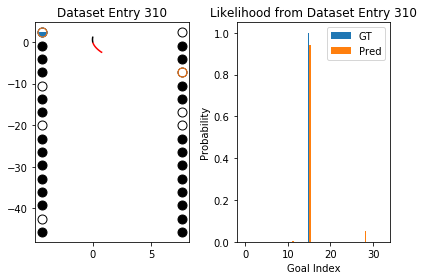

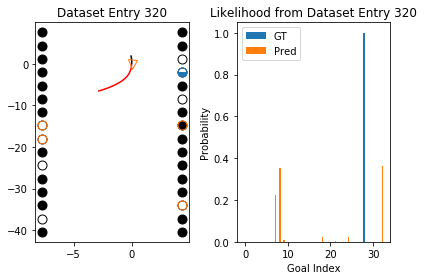

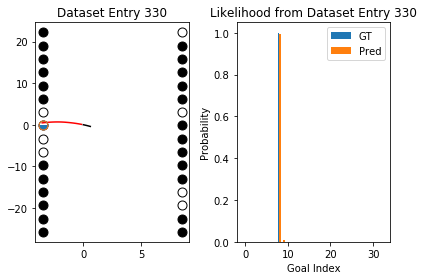

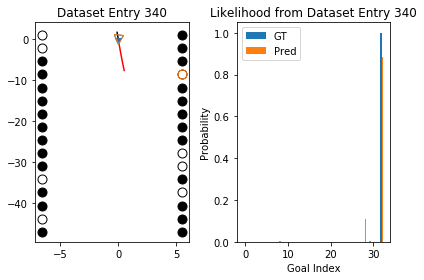

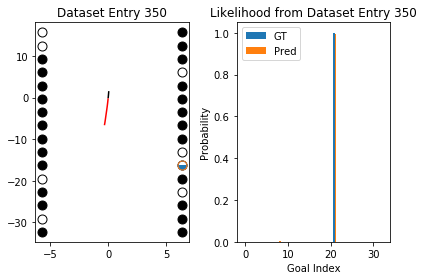

In [19]:
# Plot the result
goal_ind = np.arange(33)
bar_width = 0.35
# Recover the goal coordinates
test_goals_coords = test_goals_position.reshape((test_goals_position.shape[0], 32, 3))

for i in range(0, len(goal_pred), 10):
    plt.figure()
    plt.subplot(121)
    
    # Plot the vehicle trajectory in the snippet
    plt.plot(test_hist_traj[i][:,0], test_hist_traj[i][:,1], 'k')
    plt.plot(test_future_traj[i][:,0], test_future_traj[i][:,1], 'r')
    
    # Plot the occupancy in the snippet
    for goal in test_goals_coords[i]:
        if goal[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
        else:
            plt.plot(goal[0], goal[1], 'ko', markersize = 9)
    
    # Get the ground truth intention
    gt_idx = np.argmax(test_one_hot_goal[i])
    # Predictions above a threshold
    thres = 1e-2
    best_k_idx = [k for k, p in enumerate(goal_pred[i]) if p >= thres]
    if gt_idx == 32: # If it is "-1" -> undetermined 
        plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    else:
        plt.plot(test_goals_coords[i][gt_idx][0], test_goals_coords[i][gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    
    for j in best_k_idx:
        if j == 32:
            plt.plot(0, 0, 'v', fillstyle='none', color = '#ff770e', markersize = 9)
        else:
            plt.plot(test_goals_coords[i][j][0], test_goals_coords[i][j][1], 'o', fillstyle='none', color = '#ff770e', markersize = 9)
            
    plt.title('Dataset Entry %d' % i)
    
    plt.subplot(122)
    p1 = plt.bar(goal_ind - bar_width/2, test_one_hot_goal[i], bar_width, label='GT')
    p2 = plt.bar(goal_ind + bar_width/2, goal_pred[i], bar_width, label='Pred')
    plt.xlabel('Goal Index')
    plt.ylabel('Probability')
    plt.title('Likelihood from Dataset Entry %d' % i)
    plt.legend()
    plt.tight_layout()

In [12]:
# trajectory model function
def create_trajectory_model(traj_input_shape,intent_input_shape,hidden_dim,future_horizon, future_dim):

    # Input to lstm
    lstm_input = Input(shape=(traj_input_shape),name="trajectory_input")
    
    # LSTM unit
    lstm = LSTM(hidden_dim,return_state=True,name="lstm_unit")
    
    # LSTM outputs
    lstm_outputs, state_h, state_c = lstm(lstm_input)
    encoder_states = [state_h,state_c]
    
    # Input for goals
    goals_input = Input(shape=(intent_input_shape),name="goal_input")
    
    # Repeat the goal inputs
    goals_repeated= RepeatVector(future_horizon)(goals_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    
    # Decoder outputs, initialize with previous lstm states
    decoder_outputs,_,_ = decoder(goals_repeated,initial_state=encoder_states)
    
    # Shape to a time series prediction of future_horizon x features
    decoder_fully_connected = TimeDistributed(Dense(future_dim))(decoder_outputs)
    
    # Create final model
    model = Model([lstm_input,goals_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    return model

In [21]:
print('Shape of history_traj:', history_traj_data.shape)
print('Shape of intent:', one_hot_goal.shape)
print('Shape of future trajectory label:', future_traj_data.shape)

# Build Trajectory Model
traj_input_shape=(history_traj_data.shape[1], history_traj_data.shape[2])
intent_input_shape=(one_hot_goal.shape[1],)
hidden_dim = 100
future_horizon = future_traj_data.shape[1]
future_dim = future_traj_data.shape[2]
traj_model = create_trajectory_model(traj_input_shape,intent_input_shape,hidden_dim,future_horizon,future_dim)
plot_model(traj_model,to_file='traj_model.png')
print(traj_model.summary())

Shape of history_traj: (1763, 5, 3)
Shape of intent: (1763, 33)
Shape of future trajectory label: (1763, 20, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
goal_input (InputLayer)         (None, 33)           0                                            
__________________________________________________________________________________________________
trajectory_input (InputLayer)   (None, 5, 3)         0                                            
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 20, 33)       0           goal_input[0][0]                 
__________________________________________________________________________________________________
lstm_unit (LSTM)                [(None, 100), (None, 41600       trajectory_input[0][0]         

Traj Model Structure:
<img src='traj_model.png' width=300 height=300>

In [22]:
# Train the traj model
traj_history = traj_model.fit([history_traj_data, one_hot_goal], future_traj_data, epochs=100, validation_split=0.33)

Train on 1181 samples, validate on 582 samples
Epoch 1/100
1181/1181 [==============================] - 8s 7ms/step - loss: 2.1339 - acc: 0.6758 - val_loss: 0.8522 - val_acc: 0.7664
Epoch 2/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.7668 - acc: 0.8481 - val_loss: 0.6015 - val_acc: 0.8666
Epoch 3/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.5899 - acc: 0.8602 - val_loss: 0.5547 - val_acc: 0.8978
Epoch 4/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.4839 - acc: 0.8711 - val_loss: 0.3849 - val_acc: 0.9182
Epoch 5/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.3575 - acc: 0.8940 - val_loss: 0.2988 - val_acc: 0.9271
Epoch 6/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.3182 - acc: 0.9027 - val_loss: 0.3127 - val_acc: 0.9277
Epoch 7/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.2974 - acc: 0.9040 - val_loss: 0.2855 - val_acc: 0.9393
Epoch 8/

Epoch 61/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1371 - acc: 0.9210 - val_loss: 0.2260 - val_acc: 0.9388
Epoch 62/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1467 - acc: 0.9229 - val_loss: 0.1913 - val_acc: 0.9418
Epoch 63/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1390 - acc: 0.9252 - val_loss: 0.1972 - val_acc: 0.9446
Epoch 64/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1337 - acc: 0.9234 - val_loss: 0.1883 - val_acc: 0.9432
Epoch 65/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1353 - acc: 0.9249 - val_loss: 0.2052 - val_acc: 0.9470
Epoch 66/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1471 - acc: 0.9237 - val_loss: 0.2119 - val_acc: 0.9201
Epoch 67/100
1181/1181 [==============================] - 2s 2ms/step - loss: 0.1355 - acc: 0.9220 - val_loss: 0.2297 - val_acc: 0.9298
Epoch 68/100
1181/1181 [========================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


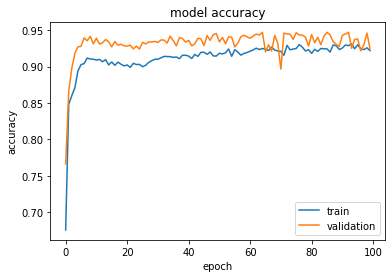

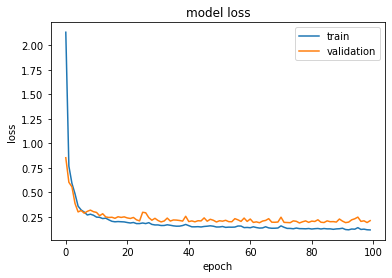

In [27]:
print(traj_history.history.keys())
# summarize history for accuracy
plt.plot(traj_history.history['acc'])
plt.plot(traj_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(traj_history.history['loss'])
plt.plot(traj_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [28]:
# save model and architecture to single file
now = datetime.now()
dt_string = now.strftime('%m_%d_%H_%M')
file_name = "traj_model_%.4f_%s.h5" % (traj_history.history['val_acc'][-1], dt_string)
goal_model.save(file_name)
print("Saved traj model to disk")

Saved traj model to disk


In [29]:
# Load model from disk
load_model = False
if load_model:
    model_files_on_disk = glob.glob('./traj_model_*.h5')
    print('Model files on disk: %s' % model_files_on_disk)
    traj_model = load_model(model_files_on_disk[-1])

# Use the traj model to predict
traj_pred = traj_model.predict([test_hist_traj, test_one_hot_goal])

/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


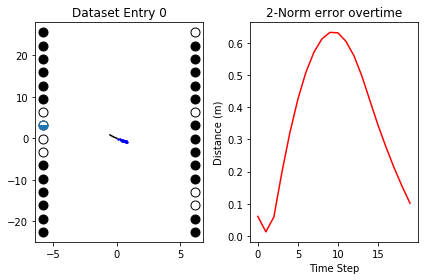

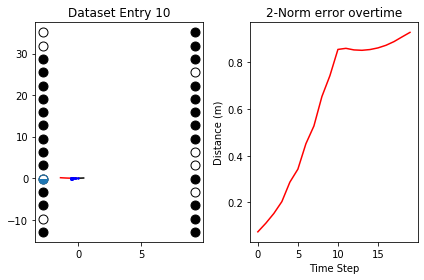

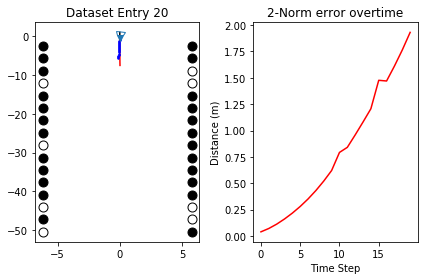

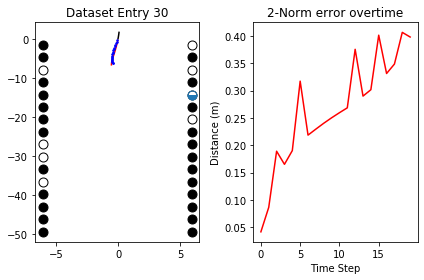

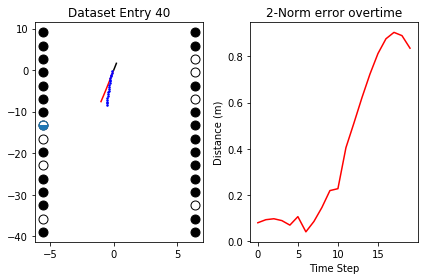

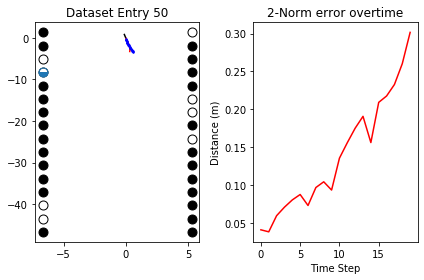

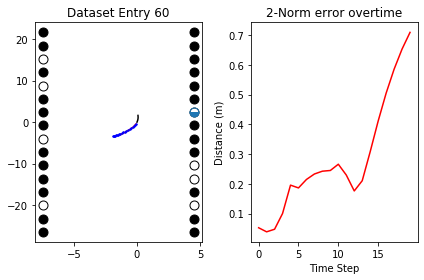

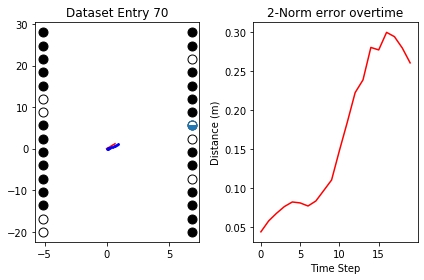

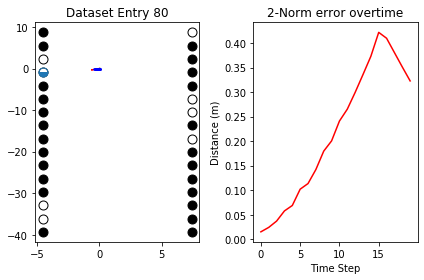

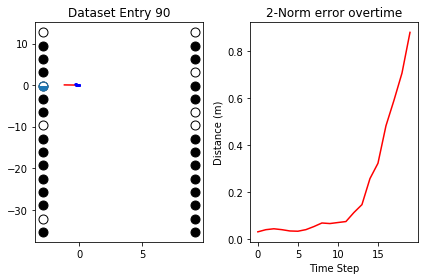

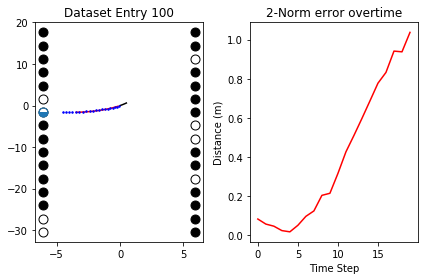

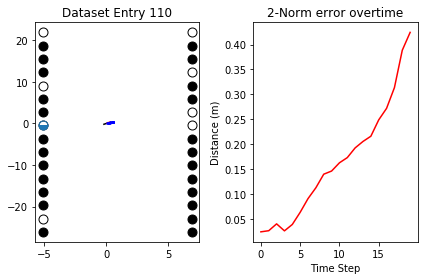

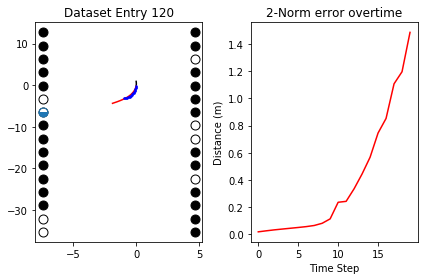

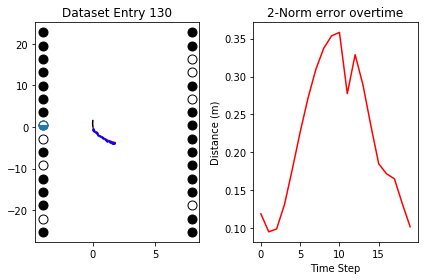

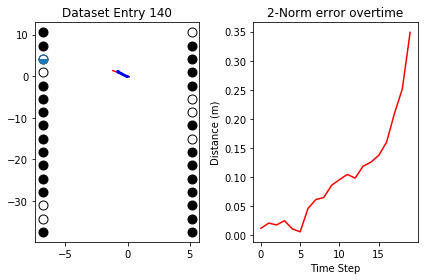

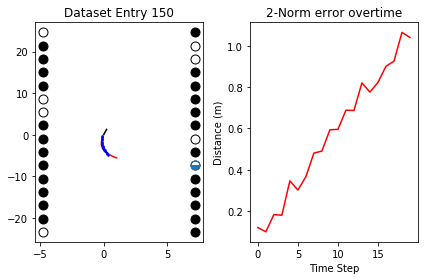

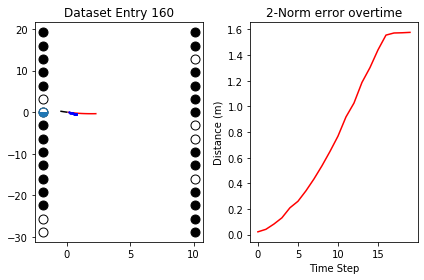

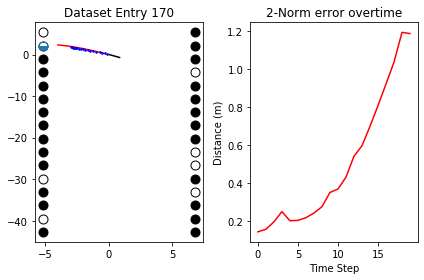

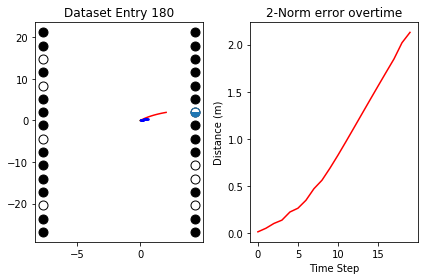

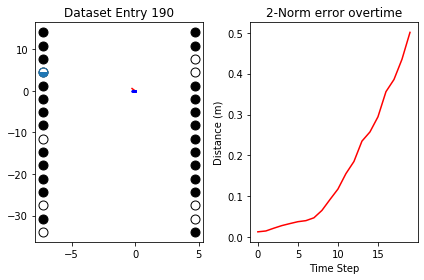

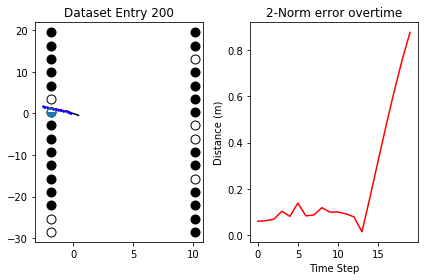

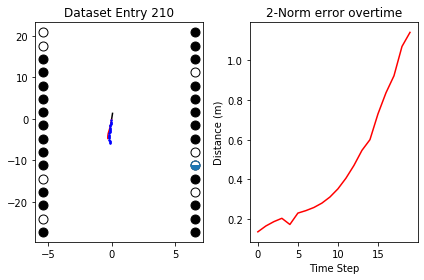

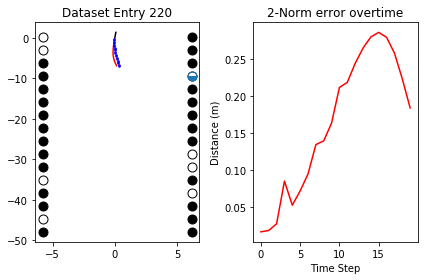

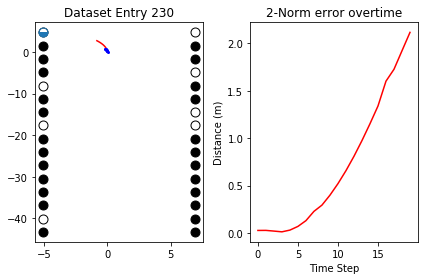

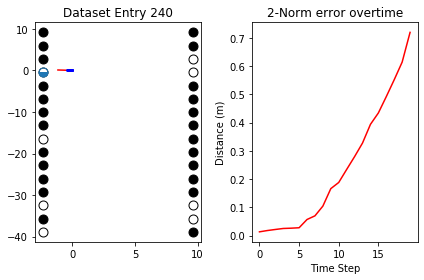

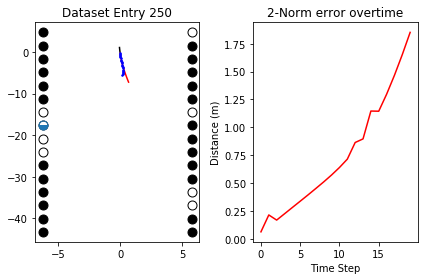

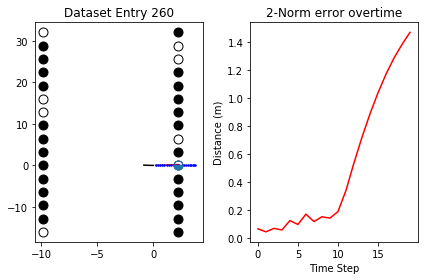

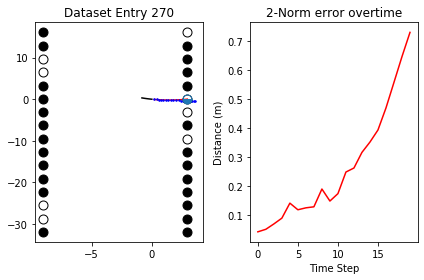

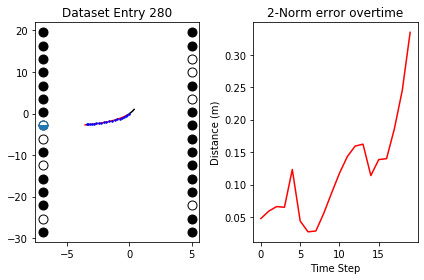

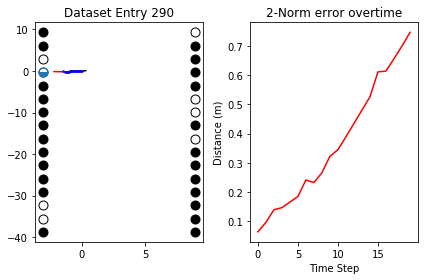

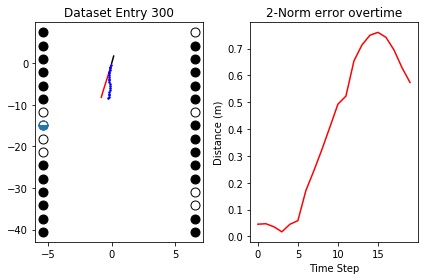

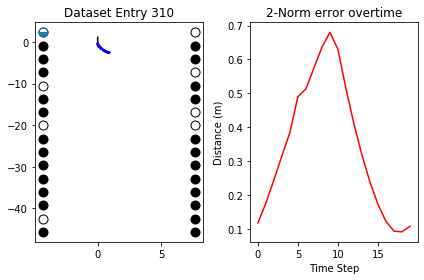

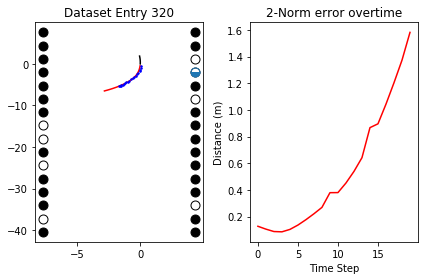

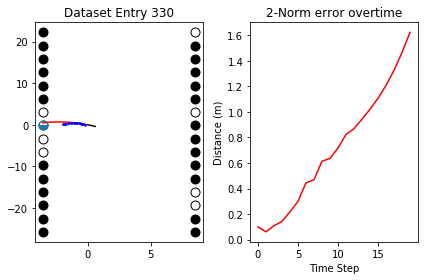

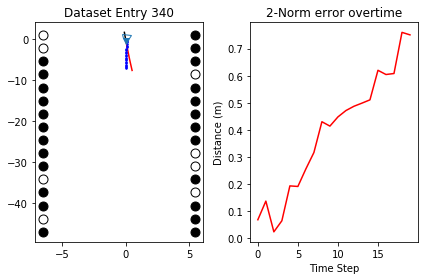

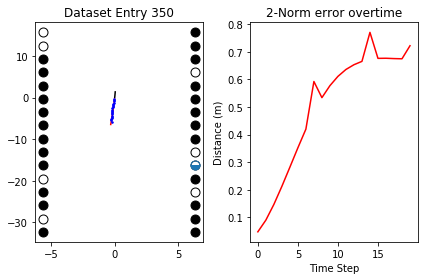

In [30]:
# Plot the result

# Recover the goal coordinates
test_goals_coords = test_goals_position.reshape((test_goals_position.shape[0], 32, 3))

for i in range(0, len(goal_pred), 10):
    plt.figure()
    plt.subplot(121)
    
    # Plot the vehicle trajectory in the snippet
    plt.plot(test_hist_traj[i][:,0], test_hist_traj[i][:,1], 'k')
    plt.plot(test_future_traj[i][:,0], test_future_traj[i][:,1], 'r')
    plt.plot(traj_pred[i][:,0], traj_pred[i][:,1], 'b.', markersize = 3)
    
    # Plot the occupancy in the snippet
    for goal in test_goals_coords[i]:
        if goal[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
        else:
            plt.plot(goal[0], goal[1], 'ko', markersize = 9)
            
    # Get the ground truth intention
    gt_idx = np.argmax(test_one_hot_goal[i])
    if gt_idx == 32: # If it is "-1" -> undetermined 
        plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    else:
        plt.plot(test_goals_coords[i][gt_idx][0], test_goals_coords[i][gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)

            
    plt.title('Dataset Entry %d' % i)
    
    plt.subplot(122)
    diff = np.linalg.norm(test_future_traj[i][:,0:2] - traj_pred[i][:,0:2], axis=1)
    plt.plot(diff, 'r')
    plt.title('2-Norm error overtime')
    plt.xlabel('Time Step')
    plt.ylabel('Distance (m)')
    
    plt.tight_layout()